# Comparison of NUTS-2 vs NUTS-3 Resolution

This notebook compares the total ton-kilometers (Tkm) between NUTS-3 and NUTS-2 aggregated datasets to validate the aggregation process.

In [1]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## Load Data

## Understanding the Aggregation

The NUTS-2 aggregation uses **weighted averaging** to preserve total Tkm:

**For routes with same NUTS-2 origin-destination:**
- Route 1: `F₁ tons × D₁ km = Tkm₁`
- Route 2: `F₂ tons × D₂ km = Tkm₂`

**After aggregation:**
- Total Flow: `F_total = F₁ + F₂` (sum)
- Weighted Avg Distance: `D_avg = (F₁×D₁ + F₂×D₂) / (F₁ + F₂)`
- Total Tkm: `F_total × D_avg = (F₁ + F₂) × [(F₁×D₁ + F₂×D₂) / (F₁ + F₂)]`
- Simplifies to: `= F₁×D₁ + F₂×D₂ = Tkm₁ + Tkm₂` ✓

**Therefore: Total Tkm is mathematically preserved during aggregation!**

If you see different Tkm values, the datasets likely have **different filters applied**.

In [2]:
# Define paths - IMPORTANT: Use datasets with SAME filters!
# Both datasets must have: cross-border only + 360km minimum distance
nuts3_dir = Path('input_data/sm_nuts3_360km_crossborder')  # NUTS-3 with 360km + cross-border
nuts2_dir = Path('input_data/sm_nuts2_international_aggregated')  # NUTS-2 aggregated

print("="*70)
print("COMPARING DATASETS WITH IDENTICAL FILTERS")
print("="*70)
print(f"\nNUTS-3 source: {nuts3_dir}")
print(f"NUTS-2 source: {nuts2_dir}")
print(f"\nBoth datasets MUST have:")
print(f"  ✓ Cross-border filter (origin/dest in different countries)")
print(f"  ✓ Minimum 360km distance")
print(f"  ✓ Same NUTS region filter")
print("="*70)

# Load NUTS-3 data
with open(nuts3_dir / 'Odpair.yaml', 'r') as f:
    nuts3_odpairs = yaml.safe_load(f)

with open(nuts3_dir / 'Path.yaml', 'r') as f:
    nuts3_paths = yaml.safe_load(f)

# Load NUTS-2 data
with open(nuts2_dir / 'Odpair.yaml', 'r') as f:
    nuts2_odpairs = yaml.safe_load(f)

with open(nuts2_dir / 'Path.yaml', 'r') as f:
    nuts2_paths = yaml.safe_load(f)

print(f"\nNUTS-3 OD-pairs loaded: {len(nuts3_odpairs):,}")
print(f"NUTS-2 OD-pairs loaded: {len(nuts2_odpairs):,}")

COMPARING DATASETS WITH IDENTICAL FILTERS

NUTS-3 source: input_data\sm_nuts3_360km_crossborder
NUTS-2 source: input_data\sm_nuts2_international_aggregated

Both datasets MUST have:
  ✓ Cross-border filter (origin/dest in different countries)
  ✓ Minimum 360km distance
  ✓ Same NUTS region filter

NUTS-3 OD-pairs loaded: 603,174
NUTS-2 OD-pairs loaded: 2,928


## Calculate Total Ton-Kilometers (Tkm)

In [3]:
def calculate_tkm(odpairs, paths):
    """
    Calculate total ton-kilometers: sum of F[0] * path_length for all OD-pairs
    """
    total_tkm = 0
    tkm_list = []
    
    for odpair, path in zip(odpairs, paths):
        # F[0] is the traffic flow for the first year
        flow = odpair['F'][0]
        # path_length is the total distance
        distance = path['length']
        
        tkm = flow * distance
        total_tkm += tkm
        tkm_list.append(tkm)
    
    return total_tkm, tkm_list

# Calculate for both datasets
nuts3_total_tkm, nuts3_tkm_list = calculate_tkm(nuts3_odpairs, nuts3_paths)
nuts2_total_tkm, nuts2_tkm_list = calculate_tkm(nuts2_odpairs, nuts2_paths)

print(f"\n=== Total Ton-Kilometers Comparison ===")
print(f"NUTS-3 Total Tkm: {nuts3_total_tkm:,.0f}")
print(f"NUTS-2 Total Tkm: {nuts2_total_tkm:,.0f}")
print(f"\nDifference: {nuts2_total_tkm - nuts3_total_tkm:,.0f} Tkm")
print(f"Relative difference: {((nuts2_total_tkm - nuts3_total_tkm) / nuts3_total_tkm * 100):.4f}%")


=== Total Ton-Kilometers Comparison ===
NUTS-3 Total Tkm: 26,808,031,958
NUTS-2 Total Tkm: 26,808,031,958

Difference: 0 Tkm
Relative difference: 0.0000%


## Additional Statistics

In [4]:
# Create summary dataframe
summary_data = {
    'Metric': [
        'Number of OD-pairs',
        'Total Tkm',
        'Average Tkm per OD-pair',
        'Median Tkm per OD-pair',
        'Min Tkm per OD-pair',
        'Max Tkm per OD-pair',
        'Average Path Length (km)',
        'Total Flow (F[0])'
    ],
    'NUTS-3': [
        len(nuts3_odpairs),
        f"{nuts3_total_tkm:,.0f}",
        f"{np.mean(nuts3_tkm_list):,.0f}",
        f"{np.median(nuts3_tkm_list):,.0f}",
        f"{np.min(nuts3_tkm_list):,.0f}",
        f"{np.max(nuts3_tkm_list):,.0f}",
        f"{np.mean([p['length'] for p in nuts3_paths]):.1f}",
        f"{sum(od['F'][0] for od in nuts3_odpairs):,.0f}"
    ],
    'NUTS-2': [
        len(nuts2_odpairs),
        f"{nuts2_total_tkm:,.0f}",
        f"{np.mean(nuts2_tkm_list):,.0f}",
        f"{np.median(nuts2_tkm_list):,.0f}",
        f"{np.min(nuts2_tkm_list):,.0f}",
        f"{np.max(nuts2_tkm_list):,.0f}",
        f"{np.mean([p['length'] for p in nuts2_paths]):.1f}",
        f"{sum(od['F'][0] for od in nuts2_odpairs):,.0f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n=== Summary Statistics ===")
print(summary_df.to_string(index=False))


=== Summary Statistics ===
                  Metric         NUTS-3         NUTS-2
      Number of OD-pairs         603174           2928
               Total Tkm 26,808,031,958 26,808,031,958
 Average Tkm per OD-pair         44,445      9,155,749
  Median Tkm per OD-pair          8,835        639,238
     Min Tkm per OD-pair            226          1,981
     Max Tkm per OD-pair     17,169,300  1,247,126,491
Average Path Length (km)          872.9         1352.3
       Total Flow (F[0])     48,647,430     48,647,430


## Visualization: Distribution of Tkm per OD-pair

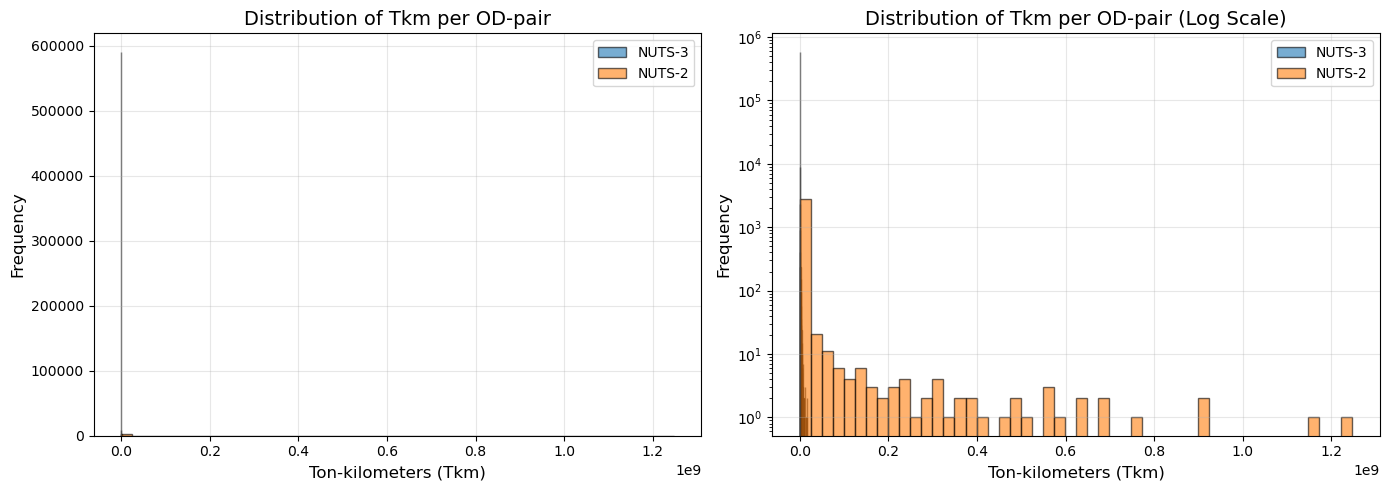

Distribution plot saved as 'tkm_distribution_comparison.png'


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram comparison
axes[0].hist(nuts3_tkm_list, bins=50, alpha=0.6, label='NUTS-3', edgecolor='black')
axes[0].hist(nuts2_tkm_list, bins=50, alpha=0.6, label='NUTS-2', edgecolor='black')
axes[0].set_xlabel('Ton-kilometers (Tkm)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Tkm per OD-pair', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log scale histogram for better visibility
axes[1].hist(nuts3_tkm_list, bins=50, alpha=0.6, label='NUTS-3', edgecolor='black')
axes[1].hist(nuts2_tkm_list, bins=50, alpha=0.6, label='NUTS-2', edgecolor='black')
axes[1].set_xlabel('Ton-kilometers (Tkm)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Tkm per OD-pair (Log Scale)', fontsize=14)
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tkm_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Distribution plot saved as 'tkm_distribution_comparison.png'")

## Visualization: Total Tkm Bar Chart

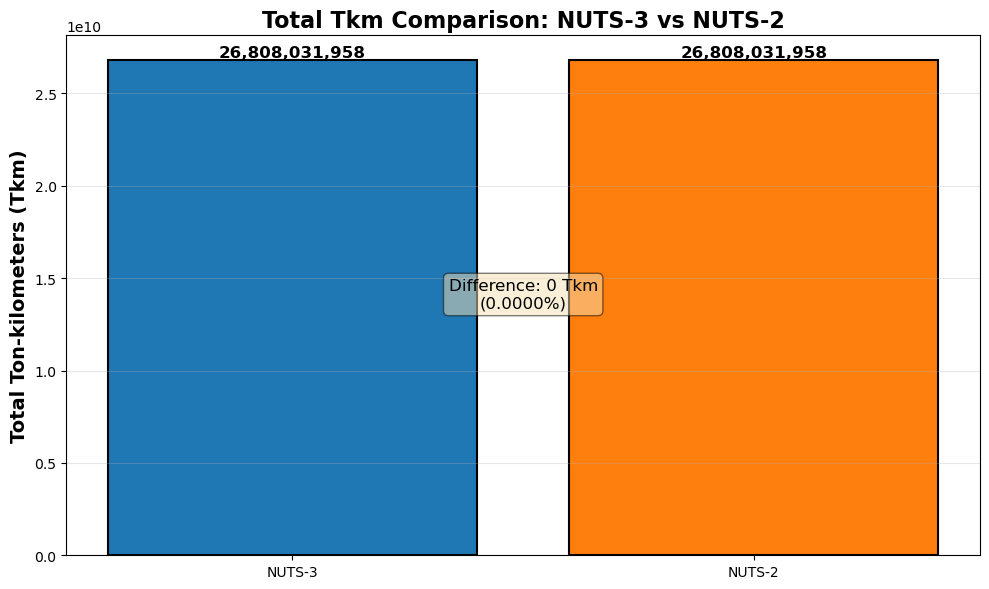

Total Tkm comparison chart saved as 'total_tkm_comparison.png'


In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

datasets = ['NUTS-3', 'NUTS-2']
tkm_values = [nuts3_total_tkm, nuts2_total_tkm]
colors = ['#1f77b4', '#ff7f0e']

bars = ax.bar(datasets, tkm_values, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, value in zip(bars, tkm_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:,.0f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Total Ton-kilometers (Tkm)', fontsize=14, fontweight='bold')
ax.set_title('Total Tkm Comparison: NUTS-3 vs NUTS-2', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add difference annotation
diff = nuts2_total_tkm - nuts3_total_tkm
diff_pct = (diff / nuts3_total_tkm * 100)
ax.text(0.5, max(tkm_values) * 0.5, 
        f'Difference: {diff:,.0f} Tkm\n({diff_pct:.4f}%)',
        ha='center', fontsize=12, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('total_tkm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Total Tkm comparison chart saved as 'total_tkm_comparison.png'")

## Flow and Distance Analysis

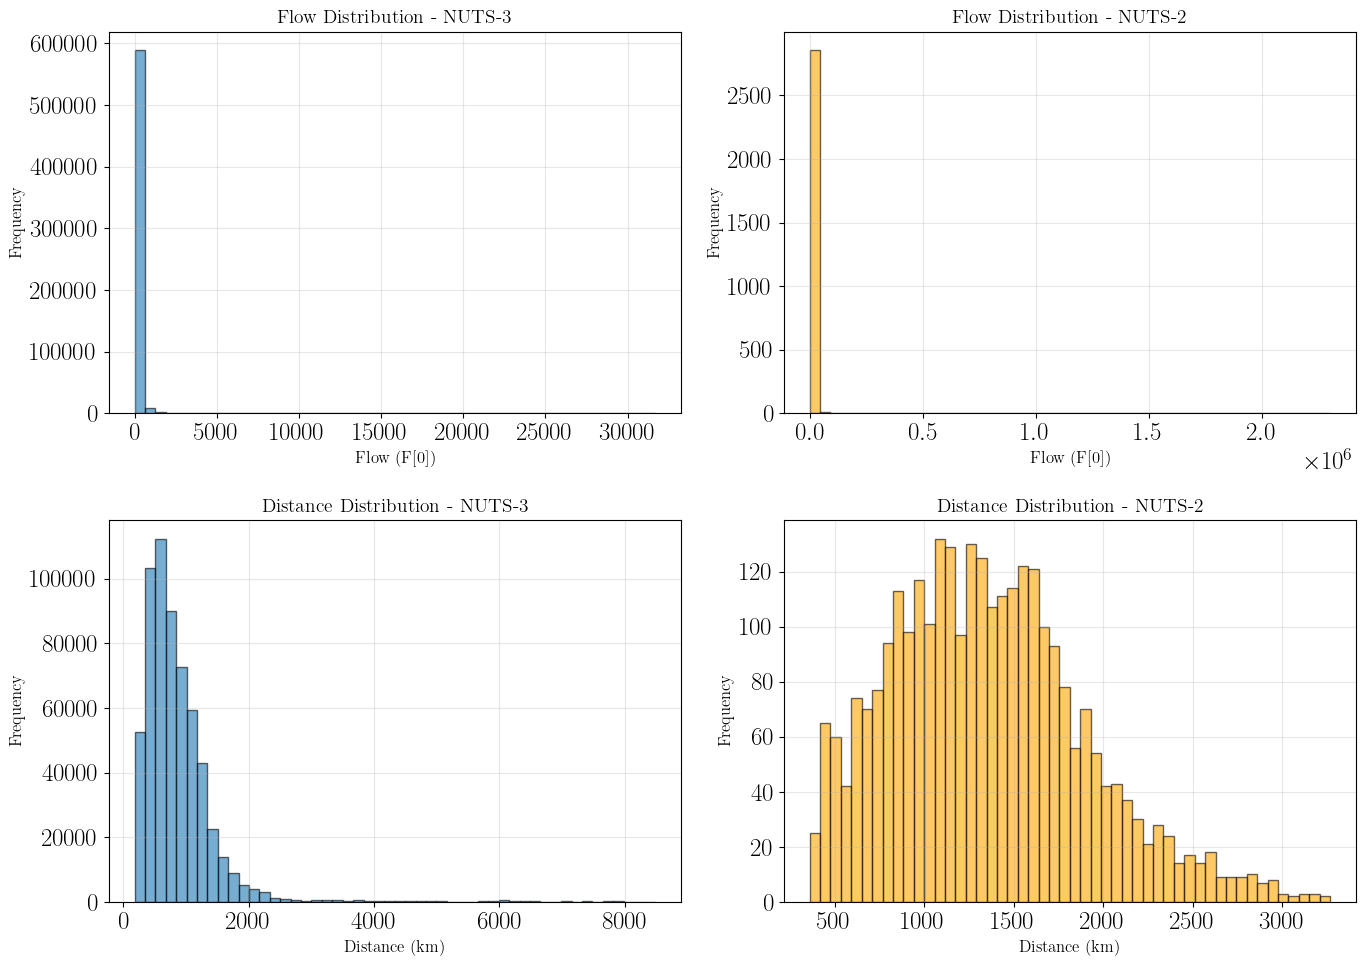

Flow and distance distributions saved as 'flow_distance_distributions.png'

=== Flow Statistics ===
NUTS-3 - Total: 48,647,430, Mean: 80.7, Median: 11.2
NUTS-2 - Total: 48,647,430, Mean: 16,614.6, Median: 516.9

=== Distance Statistics ===
NUTS-3 - Mean: 872.9 km, Median: 734.0 km
NUTS-2 - Mean: 1352.3 km, Median: 1312.4 km


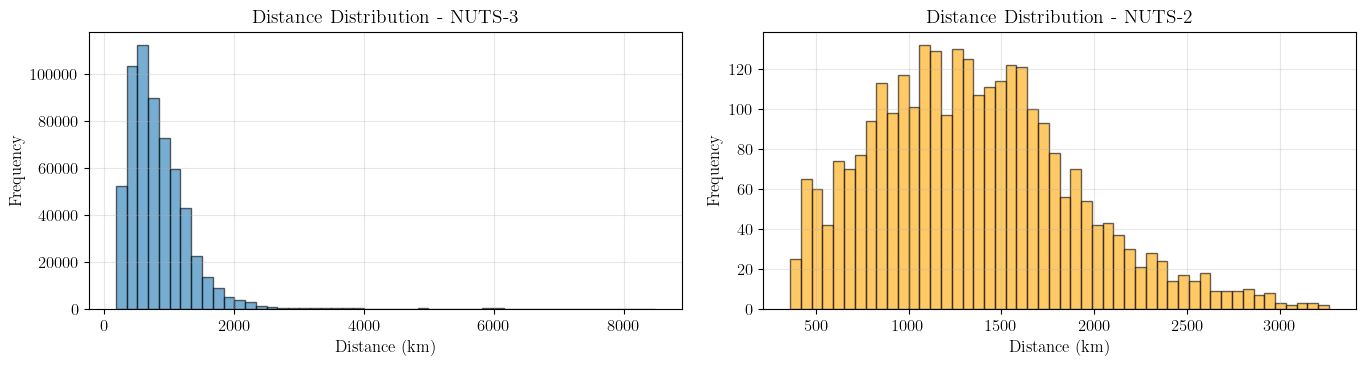

Distance distributions saved as 'distance_distributions.png'


In [12]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Garamond",
    "font.size": 18,
})
# Extract flows and distances
nuts3_flows = [od['F'][0] for od in nuts3_odpairs]
nuts3_distances = [p['length'] for p in nuts3_paths]

nuts2_flows = [od['F'][0] for od in nuts2_odpairs]
nuts2_distances = [p['length'] for p in nuts2_paths]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Flow distribution
axes[0, 0].hist(nuts3_flows, bins=50, alpha=0.6, label='NUTS-3', edgecolor='black')
axes[0, 0].set_xlabel('Flow (F[0])', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Flow Distribution - NUTS-3', fontsize=14)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(nuts2_flows, bins=50, alpha=0.6, label='NUTS-2', color='orange', edgecolor='black')
axes[0, 1].set_xlabel('Flow (F[0])', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Flow Distribution - NUTS-2', fontsize=14)
axes[0, 1].grid(True, alpha=0.3)

# Distance distribution
axes[1, 0].hist(nuts3_distances, bins=50, alpha=0.6, label='NUTS-3', edgecolor='black')
axes[1, 0].set_xlabel('Distance (km)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Distance Distribution - NUTS-3', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(nuts2_distances, bins=50, alpha=0.6, label='NUTS-2', color='orange', edgecolor='black')
axes[1, 1].set_xlabel('Distance (km)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Distance Distribution - NUTS-2', fontsize=14)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('flow_distance_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Flow and distance distributions saved as 'flow_distance_distributions.png'")

# Print statistics
print(f"\n=== Flow Statistics ===")
print(f"NUTS-3 - Total: {sum(nuts3_flows):,.0f}, Mean: {np.mean(nuts3_flows):,.1f}, Median: {np.median(nuts3_flows):,.1f}")
print(f"NUTS-2 - Total: {sum(nuts2_flows):,.0f}, Mean: {np.mean(nuts2_flows):,.1f}, Median: {np.median(nuts2_flows):,.1f}")

print(f"\n=== Distance Statistics ===")
print(f"NUTS-3 - Mean: {np.mean(nuts3_distances):.1f} km, Median: {np.median(nuts3_distances):.1f} km")
print(f"NUTS-2 - Mean: {np.mean(nuts2_distances):.1f} km, Median: {np.median(nuts2_distances):.1f} km")
# Create a separate plot for distance distributions
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# Distance distribution for NUTS-3
ax[0].hist(nuts3_distances, bins=50, alpha=0.6, label='NUTS-3', edgecolor='black')
ax[0].set_xlabel('Distance (km)', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12)
ax[0].set_title('Distance Distribution - NUTS-3', fontsize=14)
ax[0].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)

ax[0].grid(True, alpha=0.3)

# Distance distribution for NUTS-2
ax[1].hist(nuts2_distances, bins=50, alpha=0.6, label='NUTS-2', color='orange', edgecolor='black')
ax[1].set_xlabel('Distance (km)', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12)
ax[1].set_title('Distance Distribution - NUTS-2', fontsize=14)
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)

ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('aggregation_distance_distributions.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("Distance distributions saved as 'distance_distributions.png'")

## Validation Summary

In [8]:
print("\n" + "="*60)
print("VALIDATION SUMMARY")
print("="*60)

print(f"\n1. Data Reduction:")
print(f"   - OD-pairs reduced from {len(nuts3_odpairs):,} to {len(nuts2_odpairs):,}")
print(f"   - Reduction: {((len(nuts3_odpairs) - len(nuts2_odpairs)) / len(nuts3_odpairs) * 100):.1f}%")

print(f"\n2. Total Transportation Volume (Tkm):")
print(f"   - NUTS-3: {nuts3_total_tkm:,.0f} Tkm")
print(f"   - NUTS-2: {nuts2_total_tkm:,.0f} Tkm")
print(f"   - Difference: {abs(nuts2_total_tkm - nuts3_total_tkm):,.0f} Tkm ({abs((nuts2_total_tkm - nuts3_total_tkm) / nuts3_total_tkm * 100):.4f}%)")

print(f"\n3. Total Flow Preservation:")
total_flow_nuts3 = sum(nuts3_flows)
total_flow_nuts2 = sum(nuts2_flows)
print(f"   - NUTS-3 total flow: {total_flow_nuts3:,.0f}")
print(f"   - NUTS-2 total flow: {total_flow_nuts2:,.0f}")
print(f"   - Flow preservation: {(total_flow_nuts2 / total_flow_nuts3 * 100):.2f}%")

print(f"\n4. Average Distance:")
print(f"   - NUTS-3: {np.mean(nuts3_distances):.1f} km")
print(f"   - NUTS-2: {np.mean(nuts2_distances):.1f} km")

if abs((nuts2_total_tkm - nuts3_total_tkm) / nuts3_total_tkm * 100) < 0.01:
    print(f"\n✓ VALIDATION PASSED: Total Tkm preserved within 0.01% tolerance")
else:
    print(f"\n⚠ WARNING: Total Tkm difference exceeds 0.01% tolerance")

print("\n" + "="*60)


VALIDATION SUMMARY

1. Data Reduction:
   - OD-pairs reduced from 603,174 to 2,928
   - Reduction: 99.5%

2. Total Transportation Volume (Tkm):
   - NUTS-3: 26,808,031,958 Tkm
   - NUTS-2: 26,808,031,958 Tkm
   - Difference: 0 Tkm (0.0000%)

3. Total Flow Preservation:
   - NUTS-3 total flow: 48,647,430
   - NUTS-2 total flow: 48,647,430
   - Flow preservation: 100.00%

4. Average Distance:
   - NUTS-3: 872.9 km
   - NUTS-2: 1352.3 km

✓ VALIDATION PASSED: Total Tkm preserved within 0.01% tolerance

